## This notebook contains all steps to import, clean, aggregate and merge the 3 datasets I queried from the MusicBrainz database.

[Queries located here](queries)

### The three datasets consist of:
### allalbums_newmeta2.csv - All recordings by the bands **The Beatles** & **The Rolling Stones**.

### bs_covers.csv - All cover versions (re-recordings) of original material from both bands.

### work_cover.csv - A lookup of the workids representing the original songs from each band. 


In [132]:
# Import data and modules. References to Plotly may be ignored for now, though the library offers far nicer 
# visualizations over basic Pandas and Matplotlib.

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer


import plotly.plotly as py
import plotly.tools as tls
tls.embed('https://plot.ly/~cufflinks/8')
import cufflinks as cf

py.sign_in('maxrose', '••••••••••')

cf.set_config_file(offline=True, world_readable=False, theme='ggplot')

plt.rcParams['figure.figsize'] = 8, 6

### Frame with all cover versions
covers = pd.read_table('data/bs_covers.csv', encoding= 'utf-8',header=0,delimiter='|')

### Frame with workid and is_cover (written by either Beatles or Stones)
is_cover = pd.read_csv("data/work_cover.csv")

### Frame with source data for all recordings by Beatle and stones
bs = pd.read_table('data/allalbums_newmeta2.csv', encoding= 'utf-8',header=0,delimiter='|')
### fix incorrect releasedates
bs.set_value(bs.releasename.str.contains("Meet The Beatles"), 'releasedate', '1964-01-20')
bs.set_value(bs.releasename.str.contains("Singles Collection: The London Years"), 'releasedate', '1989-08-15')
bs.set_value(bs.releasename.str.contains("The Very Best of the Rolling Stones 1964-1971"), 'releasedate', '2011-01-01')
bs.set_value(bs.releasename.str.contains("Best Of the Beatles"), 'releasedate', '1997-01-01')
bs.set_value(bs.releasename.str.contains("1962 Live Recordings"), 'releasedate', '1988-01-01')
bs.set_value(bs.releasename.str.contains("Rockin' at the Star-Club"), 'releasedate', '1991-01-01')
bs.set_value(bs.releasename.str.contains("Biggest Mistake"), 'releasedate', '2006-01-01')
bs.set_value(bs.releasename.str.contains("Rolled Gold"), 'releasedate', '2007-11-12')
bs.set_value(bs.releasename.str.contains("Rewind"), 'releasedate', '1984-07-01')
bs.set_value(bs.releasename.str.contains("Rewind (1971–1984)"), 'releasedate', '1984-07-01')
bs.set_value(bs.releasename.str.contains("Hot Rocks"), 'releasedate', '1971-01-01')
bs.set_value(bs.releasename.str.contains("Highwire"), 'releasedate', '1991-01-01')
bs.set_value(bs.releasename.str.contains("Sad Sad Sad"), 'releasedate', '1990-01-01')
bs.set_value(bs.releasename.str.contains("Highwire"), 'releasedate', '1991-01-01')
bs.set_value(bs.releasename.str.contains("Perfect Collection"), 'releasedate', '1997-01-01')
bs.set_value(bs.releasename.str.contains("Reeperbahn"), 'releasedate', '1996-01-01')
bs.set_value(bs.releasename.str.contains("The Beatles Best: Super Star Hit Collection"), 'releasedate', '2010-01-01')
bs.set_value(bs.releasename.str.contains("The Best of Beatles"), 'releasedate', '1999-01-01')
bs.set_value(bs.releasename.str.contains("The Beatles Beat"), 'releasedate', '1964-04-01')
bs.set_value(bs.releasename.str.contains("Star-Club In Hamburg"), 'releasedate', '1977-01-01')
### format releasedate as datetime
bs['releasedate'] = pd.to_datetime(pd.Series(bs.releasedate))
#bs.head(4)

## Ultimately the year (of the releasedate) is an important feature,I took the time to manually look up and implement code to fix.
### In my inital SQL query I created a dummy releasedate of "1962-01-01" for items that had null release dates. It turns out that was a poor choice, and a number of compilations, oddball foreign releases and live releases skewed the releasedates for a large number of songs.

In [145]:
# Update various songname mistakes - better web-scraping matches for lyrics
bs.set_value(bs.songname.str.contains('Keep'), 'songname', 'Keep Your Hands Off My Baby')
bs.set_value(bs.songname.str.contains(u"Baby You’re a Rich Man"), 'songname', "Baby, You're a Rich Man")
bs.set_value(bs.songname.str.contains(u"It's Only Rock 'n' Roll "), 'songname', "It's Only Rock 'n Roll (But I Like It)")
bs.set_value(bs.songname.str.contains(u"When I’m Sixty‐Four"), 'songname', "When I'm Sixty-Four")
bs.set_value(bs.songname.str.contains(u"Ob‐La‐Di, Ob‐La‐Da"), 'songname', "Ob-La-Di, Ob-La-Da")
bs.set_value(bs.songname.str.contains(u"Sure To Fall"), 'songname', "Sure To Fall (In Love With You)")
bs.set_value(bs.songname.str.contains(u"Honey, Don’t!"), 'songname', "Honey, Don't")
bs.set_value(bs.songname.str.contains(u"Love in Vain Blues"), 'songname', "Love in Vain")
# Replace bad unicode character to apostrophe.
bs['songname'] = bs['songname'].str.replace(u"’", "'")

#misc['product_desc'] = misc['product_desc'].str.replace('\n', '')

In [146]:
### Add Times recorded for each song
vc = pd.DataFrame(bs.songname.value_counts().reset_index())
vc.columns = ['songname', 'timesrec']
bs = pd.merge(bs, vc, on='songname')

In [147]:
print bs.shape
print bs.describe()
print covers.shape
print covers.describe()

### Perform aggregations using "agg" method, accepting a dictionary.

In [148]:
### aggregations for Beatles and Rolling Stones recordings
aggregations = {
    'releasename':{'num_releases':'count'}
    ,'releasedate':{'maxreleasedate':'min'}
    ,'rating': {'avg_rating':'min'}
    ,'country_cnt':{'countries':'nunique'}
    #,'songname': {'times_rec':'value_counts'}
}
#bsagg = bs.groupby(['workid', 'artist', 'songname', 'releasename','release_group','releasedate']).agg(aggregations).reset_index()
bsagg = bs.groupby(['workid', 'artist', 'songname']).agg(aggregations).reset_index()
bsagg.columns = bsagg.columns.droplevel(1)
bsagg.columns = ['workid','artist','songname','minreleasedate','num_releases','countries','avg_rating']

In [149]:
### Prepare for scraping Lyrics
# encoding: utf-8
import requests as req
from urllib import quote_plus
from bs4 import BeautifulSoup, SoupStrainer
only_lyrics = SoupStrainer('div',class_='lyricbox')

## After trying out the Textblob library to incorporate sentiment polarity as a feature, I found "lyrics.wikia.com" to be simple to scrape the entire lyrics for most of the songs in my data, from which I will also extract sentiment analysis as an added feature.

In [150]:
### Function for scraping lyrics from Wikia using Beautiful Soup.
baseurl = 'http://lyrics.wikia.com/wiki/'
def getLyrics(workid,artist, song):
    #ssong = song.replace("’", "'")
    #print ssong
    tUrl = "%s%s:%s" %(baseurl,artist,song)
    result = req.get(tUrl)
    lyric = BeautifulSoup(result.text, 'html.parser', parse_only=only_lyrics).get_text(' ',strip=True)
    #lyrics.append(workid, song, lyric)
    return lyric


In [151]:
### Get lyrics for each song, add to aggregated data
lyrics = []
for idx, row in bsagg.iterrows():
    lyrics.append(getLyrics(row.workid, row.artist, row.songname))
bsagg['lyrics'] = lyrics

In [156]:
### Get sentiment of text
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [157]:
### Add sentiment of songname, lyrics to aggregated data
bsagg['title_sent'] = bsagg.songname.apply(detect_sentiment)
bsagg['lyric_sent'] = bsagg.lyrics.apply(detect_sentiment)

In [158]:
### clean up covers dataframe

covers['src_id'] = covers.source_artist.map({303:0,825:1}) 
#covers.drop(['srcid'], axis = 1, inplace = True)

### fill missing ratings with mean for workid where ratings exist.
means = covers[covers.rating > 0].groupby('workid').rating.mean()
covers = covers.set_index(['workid'])
covers['rating'] = covers['rating'].fillna(means)
covers = covers.reset_index()
### Fill with 0 where no ratings exist for this cover song.
covers.rating.fillna(0, inplace=True)

In [159]:
covers.head()

,workid,recording_id,source_artist,recording_artist,record_name,rec_artist_id,rating,src_id
0,245459,2889179,825,Züri West,(Bitte Baby) Blib no chli bi mir / Lue zersch ...,148091,70.00,1
1,357708,10470131,825,Cat Power,(I Can't Get No) Satisfaction,35,62.92,1
2,357708,5974631,825,Bill Cosby,(I Can't Get No) Satisfaction,91,40.00,1
3,357708,6718106,825,The Ventures,(I Can't Get No) Satisfaction,343,60.00,1
4,357708,3024003,825,Manfred Mann,(I Can't Get No) Satisfaction,820,60.00,1


In [160]:
### Aggregations for covers

aggregations = {
    'recording_id':{'times_covered':'count'}
    ,'rec_artist_id':{'artist_cnt':'nunique'}
    ,'rating': {'cov_rating_avg':'mean'}
}


coversagg = covers.groupby(['workid']).agg(aggregations).reset_index()
coversagg.columns = coversagg.columns.droplevel(1)
coversagg.columns = ['workid','artist_cnt','cov_rating_avg','times_covered']
coversagg.shape

(221, 4)

In [161]:
### merge dataframes for analysis
### adding is_cover binary
bsagg = bsagg.merge(is_cover[['workid', 'is_cover']], on=['workid'])
### adding cover aggregates
bsagg = bsagg.merge(coversagg[['workid','artist_cnt','cov_rating_avg','times_covered']], how='left', on=['workid'])

In [162]:
import plotly
plotly.offline.iplot([{
    'x': bsagg.num_releases,
    'y': bsagg.avg_rating
    
}])

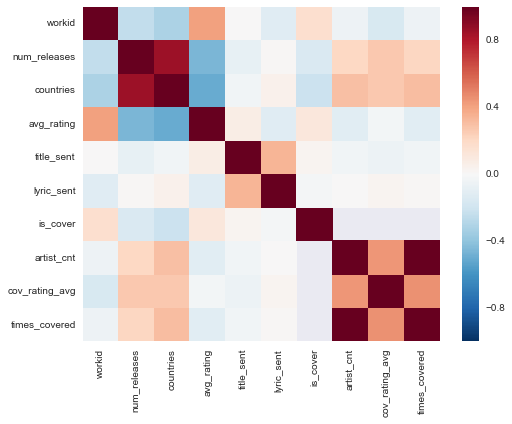

In [163]:
sns.heatmap(bsagg.corr())

In [164]:
bsagg.shape

(374, 14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e5906d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x149095850>]], dtype=object)

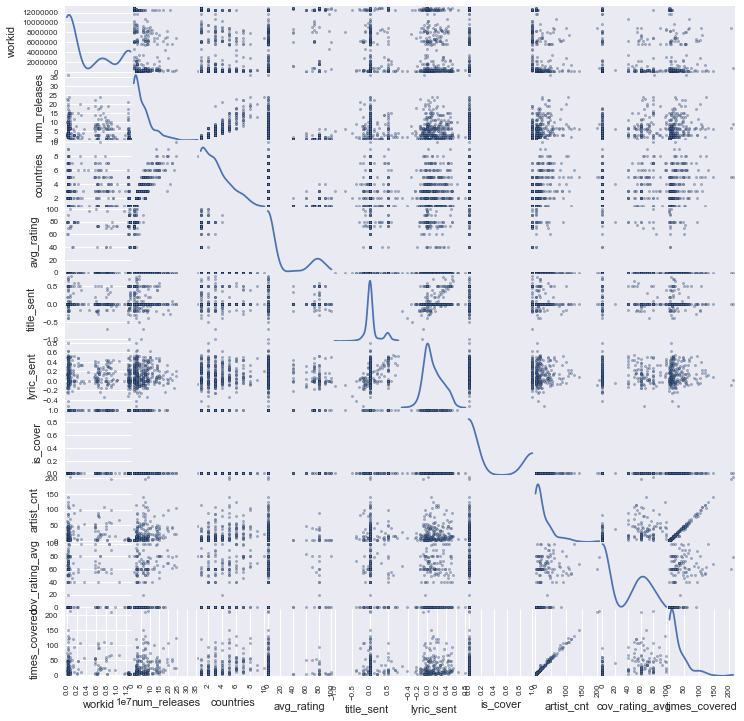

In [165]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(bsagg, alpha=0.5, figsize=(12, 12), diagonal='kde')

# Export cleaned data to csv for use in separate notebook.


In [166]:
bsagg.to_csv('data/Influence_clean.csv',sep='|',encoding='utf-8',index=False)